In [48]:
#2020/2/17 杨树澄
#读取routing程序生成的信息
#bBox的坐标为 1->左下x 2->左下y 3->右上x 4->右上y

In [75]:
def floor_to_decimal(num): #把bBox误差出来的小数都去掉
    index=30
    return int(round(num/index))*index

In [95]:
'''def read_layout(filename):
    layout_info=[]
    with open(filename) as f:
          for line in f.readlines():
                    line=line.rstrip('\n')
                    layout_info.append(line.rstrip('\n'))
    #print(layout_info[0])
    instance_info=layout_info[0][1:-1]
    instance_info=instance_info.replace("\"","")
    instance_info=instance_info.split(" ")
    orient_info=layout_info[2][1:-1]
    orient_info=orient_info.replace("\"","")
    orient_info=orient_info.split(" ")
    len_instance=len(instance_info)
    len_orient=len(orient_info)
    #print(len_instance==len_orient)
    #print(instance_info[1])
    #print(orient_info[1])
    bBox_info_pre=layout_info[1]
    bBox_info_pre=bBox_info_pre.replace("(","")
    bBox_info_pre=bBox_info_pre.replace(")","")
    bBox_info_pre=bBox_info_pre.split(" ")
    #print(bBox_info_pre)
    len_bBox_pre=len(bBox_info_pre)
    #print(len_bBox_pre)
    bBox_info=[[] for i in range(int(len_bBox_pre/4))]
    for i in range(0,int(len_bBox_pre/4)):
        bBox_info[i].append(floor_to_decimal(float(bBox_info_pre[4*i+0])))
        bBox_info[i].append(floor_to_decimal(float(bBox_info_pre[4*i+1])))
        bBox_info[i].append(floor_to_decimal(float(bBox_info_pre[4*i+2])))
        bBox_info[i].append(floor_to_decimal(float(bBox_info_pre[4*i+3])))
    #print(bBox_info)
    len_bBox=len(bBox_info)
    #print(len_bBox)
    #print(len_instance)
    print("三个数据长度是否相等？：")
    print((len_instance==len_orient)&((len_instance==len_bBox)))
    #floor_to_decimal(177.2)
    return [instance_info, orient_info, bBox_info]'''
def read_layout(filename): #io接口，用来读取SKILL输出的版图信息
    instance_info=[]
    orient_info=[]
    with open(filename[0]) as f:
        for line in f.readlines():
            line=line.rstrip('\n')
            instance_info.append(line.rstrip('\n'))  
    with open(filename[1]) as f:
        for line in f.readlines():
            line=line.rstrip('\n')
            orient_info.append(line.rstrip('\n'))
    length=len(instance_info)
    bBox_info_pre=[]
    with open(filename[2]) as f:
        for line in f.readlines():
            line=line.rstrip('\n')
            bBox_info_pre.append(line.rstrip('\n')) 
    bBox_info=[[] for i in range(int(length))]
    for i in range(0,length):
        bBox_info_pre[i]=bBox_info_pre[i].replace("(","")
        bBox_info_pre[i]=bBox_info_pre[i].replace(")","")
        bBox_info[i]=bBox_info_pre[i].split(" ")
        for k in range(0,4):
            bBox_info[i][k]=floor_to_decimal(float(bBox_info[i][k]))
    return [instance_info, orient_info, bBox_info]



In [108]:
#测试模块
dir=["routing_name.txt","routing_orient.txt","routing_bbox.txt"]

t=read_layout(dir)
print(t[2])
x_0=[x[0] for x in t[2]]
x_2=[x[2] for x in t[2]]
y_1=[y[1] for y in t[2]]
y_3=[y[3] for y in t[2]]
x_max=max([max(x_0),max(x_2)])
y_max=max([max(y_1),max(y_3)])
x_min=min([min(x_0),min(x_2)])
y_min=min([min(y_1),min(y_3)])


[[330, 270, 360, 300], [90, 180, 120, 210], [510, 270, 540, 300], [480, 270, 510, 300], [510, 360, 540, 390], [270, 120, 300, 150], [240, 240, 270, 270], [90, 480, 120, 510], [510, 480, 540, 540], [180, 270, 210, 330], [480, 300, 510, 360], [420, 90, 480, 120], [270, 360, 330, 390], [360, 120, 390, 180], [450, 270, 480, 330], [390, 270, 420, 330], [360, 480, 390, 540], [390, 120, 450, 150], [150, 180, 210, 210], [330, 630, 390, 660], [360, 60, 420, 90], [90, 150, 150, 180], [270, 60, 300, 120], [480, 480, 510, 540], [150, 360, 180, 420], [30, 210, 60, 270], [420, 510, 450, 570], [0, 210, 30, 270], [150, 480, 180, 540], [180, 480, 210, 540], [240, 480, 270, 540], [390, 150, 450, 180], [330, 600, 390, 630], [360, 330, 420, 360], [210, 480, 240, 540], [270, 390, 330, 420], [180, 390, 210, 450], [330, 540, 390, 570], [330, 570, 390, 600], [330, 390, 360, 450], [120, 330, 150, 390], [270, 450, 330, 480], [120, 480, 150, 540], [30, 270, 60, 330], [270, 420, 330, 450], [450, 180, 540, 270], [

In [109]:
import random
def randomcolor(): #随机颜色生成器
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for i in range(6):
        color += colorArr[random.randint(0,14)]
    return "#"+color

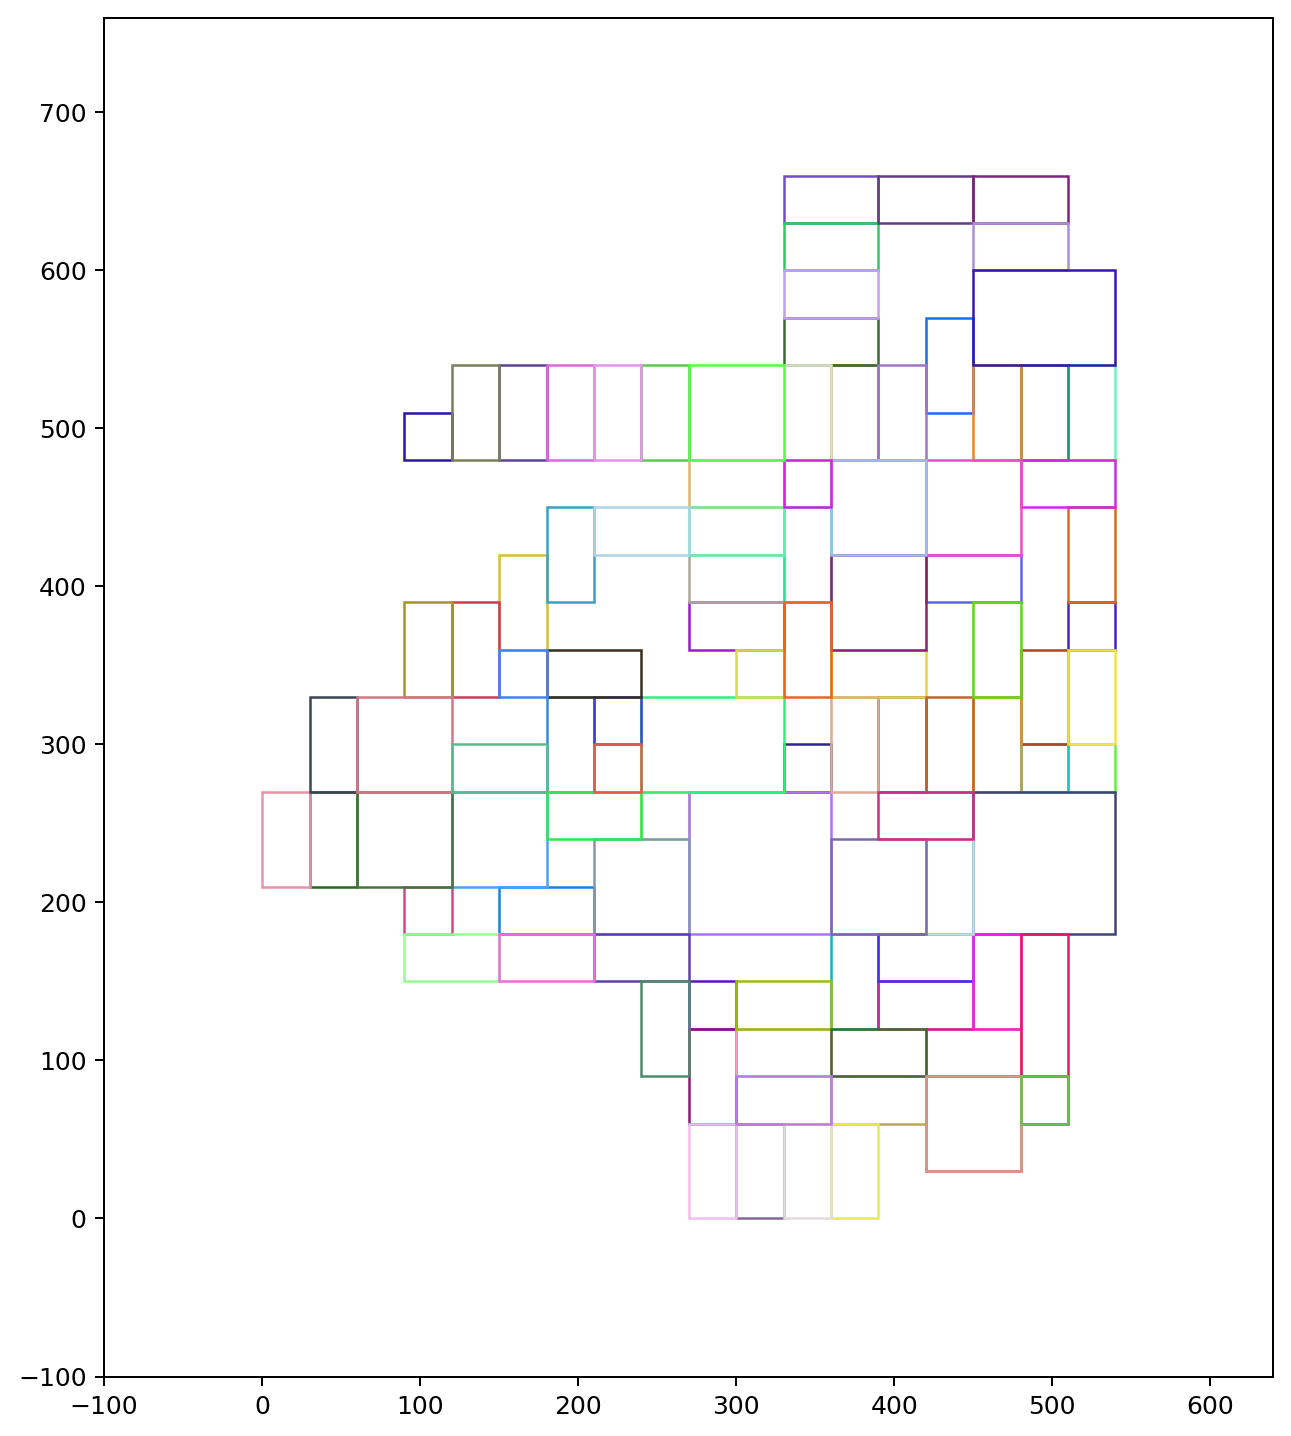

In [110]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig1 = plt.figure(figsize=(10,10),dpi=180)
ax1 = fig1.add_subplot(111, aspect='equal')
#ax1.add_patch(
#    patches.Rectangle(
#        (t[2][1][0]/1000, t[2][1][1]/1000),   # (x,y)
#        (t[2][1][2]-t[2][1][0])/1000,          # width
#        (t[2][1][3]-t[2][1][1])/1000,          # height
#    )
#)
for i in range(0,len(t[2])):
    random_color=randomcolor()
    ax1.add_patch(
        patches.Rectangle(
            (t[2][i][0], t[2][i][1]),   # (x,y)
            (t[2][i][2]-t[2][i][0]),          # width
            (t[2][i][3]-t[2][i][1]),          # height
            color=random_color,
            fill=False
        )
    )
    #print(t[2][i][3]-t[2][i][1])
    #print([t[2][i][0],t[2][i][1]])

xlim(-100+x_min,100+x_max)
ylim(-100+y_min,100+y_max)

#plt.show()
fig1.savefig('rect1.png', dpi=90, bbox_inches='tight')
#print((t[2][1][2]-t[2][1][0])/10)